# Import

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return ag

In [3]:
# Load data
df = pd.read_csv('PreprocessedData_v2.txt',
                               sep='\t',
                               decimal=',')
header = df.columns
df_arr =np.array(df, dtype='float64')
df =pd.DataFrame(df_arr, columns=header)

In [4]:
df.head(5)

,delta_t,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2,...,y,z,beta,Qx,Qy,Qz,Qw,delta_x,delta_y,delta_z
0,0.0000,-0.0029,0.0003,-0.0003,-0.0194,0.0124,-0.0022,-0.5292,-0.6538,-0.5275,...,0.221,0.402,-0.0129,0.005,0.020,0.000,1.0,0.0,0.0,0.0
1,0.0891,-0.0029,0.0013,0.0007,-0.0085,0.0023,0.0006,-0.5292,-0.6538,-0.4945,...,0.221,0.402,-0.0128,0.005,0.020,0.001,1.0,0.0,0.0,0.0
2,0.0810,-0.0039,0.0013,-0.0003,-0.0199,0.0086,-0.0024,-0.5162,-0.6538,-0.5275,...,0.221,0.402,-0.0133,0.005,0.021,0.000,1.0,0.0,0.0,0.0
3,0.3375,-0.0039,0.0013,0.0007,-0.0216,0.0054,-0.0002,-0.5162,-0.6538,-0.4945,...,0.221,0.402,-0.0129,0.005,0.020,0.000,1.0,0.0,0.0,0.0
4,0.0837,-0.0029,0.0023,0.0007,-0.0199,0.0171,0.0005,-0.5292,-0.6538,-0.4945,...,0.221,0.402,-0.0129,0.005,0.020,0.000,1.0,0.0,0.0,0.0


In [5]:
split = round(df.shape[0]*0.8)
print(split)

6142


In [6]:
# split into train and test sets
values = df.values
train = values[:split, :]
test = values[split:, :]
# split into input and outputs

#here comes the horizontal separation
train_X, train_y = train[:, :-11], train[:, -8]
test_X, test_y = test[:, :-11], test[:, -8]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

patience=40
early_stopping=EarlyStopping(monitor = 'val_loss', patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath="LSTM_beta_weights.hdf5", save_best_only=True, verbose =1)

(6142, 1, 10) (6142,) (1536, 1, 10) (1536,)


# Training for Beta (orientation)

Train on 6142 samples, validate on 1536 samples
Epoch 1/500
 - 4s - loss: 0.4283 - val_loss: 0.2407

Epoch 00001: val_loss improved from inf to 0.24072, saving model to LSTM_beta_weights.hdf5
Epoch 2/500
 - 1s - loss: 0.2795 - val_loss: 0.1643

Epoch 00002: val_loss improved from 0.24072 to 0.16432, saving model to LSTM_beta_weights.hdf5
Epoch 3/500
 - 0s - loss: 0.2118 - val_loss: 0.1764

Epoch 00003: val_loss did not improve from 0.16432
Epoch 4/500
 - 1s - loss: 0.2115 - val_loss: 0.1707

Epoch 00004: val_loss did not improve from 0.16432
Epoch 5/500
 - 1s - loss: 0.2096 - val_loss: 0.1673

Epoch 00005: val_loss did not improve from 0.16432
Epoch 6/500
 - 0s - loss: 0.2073 - val_loss: 0.1641

Epoch 00006: val_loss improved from 0.16432 to 0.16405, saving model to LSTM_beta_weights.hdf5
Epoch 7/500
 - 0s - loss: 0.2052 - val_loss: 0.1610

Epoch 00007: val_loss improved from 0.16405 to 0.16098, saving model to LSTM_beta_weights.hdf5
Epoch 8/500
 - 1s - loss: 0.2033 - val_loss: 0.1582



Epoch 00057: val_loss improved from 0.10860 to 0.10838, saving model to LSTM_beta_weights.hdf5
Epoch 58/500
 - 0s - loss: 0.1654 - val_loss: 0.1084

Epoch 00058: val_loss improved from 0.10838 to 0.10836, saving model to LSTM_beta_weights.hdf5
Epoch 59/500
 - 0s - loss: 0.1652 - val_loss: 0.1082

Epoch 00059: val_loss improved from 0.10836 to 0.10820, saving model to LSTM_beta_weights.hdf5
Epoch 60/500
 - 1s - loss: 0.1651 - val_loss: 0.1080

Epoch 00060: val_loss improved from 0.10820 to 0.10799, saving model to LSTM_beta_weights.hdf5
Epoch 61/500
 - 0s - loss: 0.1649 - val_loss: 0.1079

Epoch 00061: val_loss improved from 0.10799 to 0.10794, saving model to LSTM_beta_weights.hdf5
Epoch 62/500
 - 0s - loss: 0.1648 - val_loss: 0.1078

Epoch 00062: val_loss improved from 0.10794 to 0.10779, saving model to LSTM_beta_weights.hdf5
Epoch 63/500
 - 1s - loss: 0.1647 - val_loss: 0.1076

Epoch 00063: val_loss improved from 0.10779 to 0.10760, saving model to LSTM_beta_weights.hdf5
Epoch 64/5


Epoch 00112: val_loss improved from 0.09996 to 0.09947, saving model to LSTM_beta_weights.hdf5
Epoch 113/500
 - 0s - loss: 0.1539 - val_loss: 0.0993

Epoch 00113: val_loss improved from 0.09947 to 0.09931, saving model to LSTM_beta_weights.hdf5
Epoch 114/500
 - 1s - loss: 0.1536 - val_loss: 0.0990

Epoch 00114: val_loss improved from 0.09931 to 0.09899, saving model to LSTM_beta_weights.hdf5
Epoch 115/500
 - 0s - loss: 0.1533 - val_loss: 0.0988

Epoch 00115: val_loss improved from 0.09899 to 0.09880, saving model to LSTM_beta_weights.hdf5
Epoch 116/500
 - 0s - loss: 0.1530 - val_loss: 0.0987

Epoch 00116: val_loss improved from 0.09880 to 0.09866, saving model to LSTM_beta_weights.hdf5
Epoch 117/500
 - 0s - loss: 0.1527 - val_loss: 0.0984

Epoch 00117: val_loss improved from 0.09866 to 0.09836, saving model to LSTM_beta_weights.hdf5
Epoch 118/500
 - 0s - loss: 0.1525 - val_loss: 0.0982

Epoch 00118: val_loss improved from 0.09836 to 0.09821, saving model to LSTM_beta_weights.hdf5
Epoc


Epoch 00168: val_loss improved from 0.09167 to 0.09159, saving model to LSTM_beta_weights.hdf5
Epoch 169/500
 - 1s - loss: 0.1399 - val_loss: 0.0914

Epoch 00169: val_loss improved from 0.09159 to 0.09143, saving model to LSTM_beta_weights.hdf5
Epoch 170/500
 - 0s - loss: 0.1398 - val_loss: 0.0915

Epoch 00170: val_loss did not improve from 0.09143
Epoch 171/500
 - 0s - loss: 0.1397 - val_loss: 0.0913

Epoch 00171: val_loss improved from 0.09143 to 0.09134, saving model to LSTM_beta_weights.hdf5
Epoch 172/500
 - 0s - loss: 0.1395 - val_loss: 0.0913

Epoch 00172: val_loss improved from 0.09134 to 0.09126, saving model to LSTM_beta_weights.hdf5
Epoch 173/500
 - 0s - loss: 0.1394 - val_loss: 0.0912

Epoch 00173: val_loss improved from 0.09126 to 0.09117, saving model to LSTM_beta_weights.hdf5
Epoch 174/500
 - 0s - loss: 0.1392 - val_loss: 0.0911

Epoch 00174: val_loss improved from 0.09117 to 0.09108, saving model to LSTM_beta_weights.hdf5
Epoch 175/500
 - 0s - loss: 0.1390 - val_loss: 0

 - 0s - loss: 0.1320 - val_loss: 0.0861

Epoch 00226: val_loss improved from 0.08608 to 0.08605, saving model to LSTM_beta_weights.hdf5
Epoch 227/500
 - 0s - loss: 0.1319 - val_loss: 0.0859

Epoch 00227: val_loss improved from 0.08605 to 0.08594, saving model to LSTM_beta_weights.hdf5
Epoch 228/500
 - 0s - loss: 0.1317 - val_loss: 0.0860

Epoch 00228: val_loss did not improve from 0.08594
Epoch 229/500
 - 1s - loss: 0.1316 - val_loss: 0.0858

Epoch 00229: val_loss improved from 0.08594 to 0.08582, saving model to LSTM_beta_weights.hdf5
Epoch 230/500
 - 0s - loss: 0.1315 - val_loss: 0.0858

Epoch 00230: val_loss did not improve from 0.08582
Epoch 231/500
 - 0s - loss: 0.1314 - val_loss: 0.0857

Epoch 00231: val_loss improved from 0.08582 to 0.08572, saving model to LSTM_beta_weights.hdf5
Epoch 232/500
 - 0s - loss: 0.1313 - val_loss: 0.0857

Epoch 00232: val_loss improved from 0.08572 to 0.08569, saving model to LSTM_beta_weights.hdf5
Epoch 233/500
 - 0s - loss: 0.1311 - val_loss: 0.085


Epoch 00293: val_loss did not improve from 0.08418
Epoch 294/500
 - 0s - loss: 0.1239 - val_loss: 0.0853

Epoch 00294: val_loss did not improve from 0.08418
Epoch 295/500
 - 0s - loss: 0.1238 - val_loss: 0.0854

Epoch 00295: val_loss did not improve from 0.08418
Epoch 296/500
 - 0s - loss: 0.1237 - val_loss: 0.0855

Epoch 00296: val_loss did not improve from 0.08418
Epoch 297/500
 - 0s - loss: 0.1236 - val_loss: 0.0855

Epoch 00297: val_loss did not improve from 0.08418
Epoch 00297: early stopping


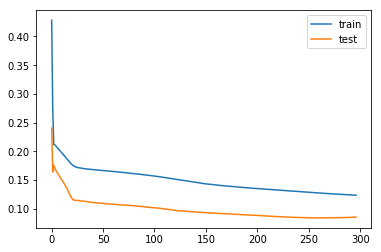

In [7]:


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks = [checkpointer,early_stopping])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [8]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [9]:
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.185
